### Setup

In [1]:
# installing
!pip install datasets
#!pip install transformers # installs v4.3.0 which seems to not contain Wav2Vec2CTC Tokenizer
!pip install git+https://github.com/huggingface/transformers
#!pip install hydra-core
#!pip install fairseq

     |████████████████████████████████| 194kB 20.1MB/s 
     |████████████████████████████████| 245kB 42.2MB/s 
     |████████████████████████████████| 112kB 57.3MB/s 
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-bb7lakfq
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-bb7lakfq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 890kB 23.3MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
  Created wheel for transformers: filename=transformers-4.5.0.dev0-cp37-none-any.whl size=1972568 sha256=6210e0fe6bded91e98895580d53f498d5c340b3553982e4b8a228d5f1f961e7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-retoy0gr/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl s

In [2]:
## load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import librosa as lb

In [5]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
## path
path = 'drive/MyDrive/Colab Notebooks/'

In [ ]:
## useful links
# https://heartbeat.fritz.ai/the-3-deep-learning-frameworks-for-end-to-end-speech-recognition-that-power-your-devices-37b891ddc380
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

### Data

In [ ]:
## useful links
# https://www.openslr.org/12

#### Data Analysis

In [ ]:
# pre-processing (frequency filtering necessary?)
# data loader (any augmentation techniques in NLP?)
# https://www.machinecurve.com/index.php/2021/02/17/easy-speech-recognition-with-machine-learning-and-huggingface-transformers/

In [ ]:
# load one recording
# audio processing: https://librosa.org/doc/main/generated/librosa.load.html
waveform, rate = lb.load('drive/MyDrive/Colab Notebooks/data/clips/1a7b4c57ea08555e6c968cbcc8875ecf70b3df42207e9556d71f1fd40b3de915d0bae21d9fe740aa56b32ad7b3dea958168bb3a84d583b3c6d46c5d2a7c5bcbe.mp3', sr = 16000)

print(waveform)
print(waveform.shape)
print(max(waveform))
print(min(waveform))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[ 1.8193451e-07 -1.6756445e-07  1.4029875e-07 ...  1.0064449e-04
 -7.5070961e-06  4.1764350e-05]
(45696,)
0.27622885
-0.28632727


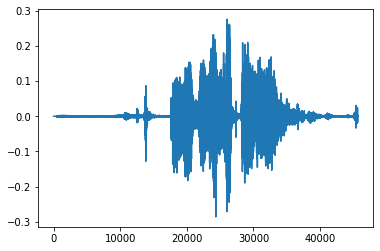

In [ ]:
# plot waveform
plt.figure()
plt.plot(waveform)
plt.show()

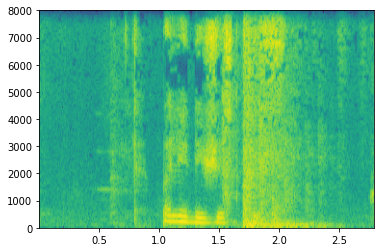

In [ ]:
# plot power spectrum density
plt.figure()
plt.specgram(waveform[1000:], Fs=16000, mode='psd', scale='dB')
plt.show()

#### Data Loader

In [ ]:
# check out dataframe
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/ASR_train.csv')
print(df.keys())
print(df.head(5))

Index(['ID', 'up_votes', 'down_votes', 'age', 'gender', 'transcription'], dtype='object')
                                                  ID  ...                  transcription
0  002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca8...  ...                        Malicka
1  0031672b4484f963c8a07babe6f713dd559539d44140e8...  ...  Ecole Elementaire Pikine Nord
2  00362ccc6b48d3ea225e12ddf8a06a9d582cccc03b0353...  ...         Cimetière de Cambérène
3  0042cdb4d4a015cddacc26d88faffdd714b7a27213d2b3...  ...                Tournalou Boune
4  00439f02fa8f0dade934bdb317199b71662e9396f6bb81...  ...             Pharmacie Golf Sud

[5 rows x 6 columns]
002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca80477704628fb1194de25fb31484fd3ef7ec27efbe87524a8d325c9e7e08d5b1e9f2b0ca2a19fe12089


In [ ]:
# suppress annoying warnings while reading audio files
import warnings
warnings.filterwarnings('ignore')

In [7]:
## read into memory (small) -> storing takes around 2hrs
## IMPORTANT: it's not persisted across sessions (why not?)
import os.path
import pandas as pd

if os.path.isfile('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft'):
    print ("File exist")
    df = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft')
else:
    print("File does not exist")

    # initialize with list
    audio_signals = len(df['ID'])*[[0]]
    df['audio_signal'] = audio_signals

    # functional but not elegant (nor fast probably)
    for k in range(100): # len(df)
      id = df.iloc[k]['ID']
      path_data = os.path.join('drive/MyDrive/Colab Notebooks/data/clips/', id+'.mp3')
      waveform, rate = lb.load(path_data, sr = 16000)
      df.at[k, 'audio_signal'] = waveform

      if k % 100 == 0:
        print('file '+ str(k))

    # store as faster feather format
    df[:100].to_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft')


File exist


In [ ]:
# not anymore needed if above code snippet works as expected
df2 = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio.ft')

In [ ]:
# NOT REQUIRED for now (but for later if we want to do dataset augmentation)
class dataloader(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data, audio_dir):
        """
        Args:
            data: pandas file with (ID, up_votes, down_votes, age, gender, transcription)
            audio_dir: direction to audio files
        """
        # text
        self.data = data
        
        # audio
        self.audio_dir = audio_dir
        
    def __len__(self):
        return len(self.data['ID'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
        
        # load audio ------------------------------------
        audio_name = os.path.join(self.audio_dir, str(self.data['ID'][idx]))
        image = cv2.imread(img_name)
        
        # transcription ---------------------------------
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # token? -------------------------------------------
        token = self.data['tokens'][idx]
        
        # prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
        # further need to make all review the same length -> padding too short, truncating too long ones
        token_id = pad_sequences([tokenizer.convert_tokens_to_ids(token)], maxlen=token_length, truncating="post", padding="post", dtype="int")
        token_id = token_id.reshape(-1)
        
        #
        sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}
            
        return sample

### Model

#### Wav2vec2

In [ ]:
## 
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC # https://huggingface.co/facebook/wav2vec2-large-960h
from datasets import load_dataset # https://github.com/huggingface/datasets
import soundfile as sf
import torch

# load model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

#print(model.parameters)

# define function to read in sound file
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

# load dummy dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

# tokenize
input_values = tokenizer(ds["speech"][:2], return_tensors="pt", padding="longest").input_values  # Batch size 1

# retrieve logits
logits = model(input_values).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)

ModuleNotFoundError: ignored

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

for p in model.parameters():
           p.requires_grad = False

print(count_parameters(model))

315460768
0


#### XLSR Model Transformers

In [ ]:
## useful links
# https://github.com/pytorch/fairseq/tree/master/examples/wav2vec
# https://github.com/pytorch/fairseq/issues/3199
# https://bleepcoder.com/fairseq/708379224/wav2vec-2-0-inference-pipeline
# https://huggingface.co/transformers/training.html

In [ ]:
## imports
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC # https://huggingface.co/facebook/
from datasets import load_dataset
import soundfile as sf
from itertools import groupby

# model and tokenizer (warnings can be neglected?)
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
modelWav2Vec2 = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53-french were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.masked_spec_embed']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
## helpers 
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

In [ ]:
print(df[idx:idx+3]['audio_signal'])
dd = [list(l) for l in df2[idx:idx+3]['audio_signal'].values]

2    [1.8193451e-07, -1.6756445e-07, 1.4029875e-07,...
3    [1.8193451e-07, -1.6756445e-07, 1.4029875e-07,...
4    [1.8193451e-07, -1.6756445e-07, 1.4029875e-07,...
Name: audio_signal, dtype: object
79104


In [ ]:
df2[idx:idx+1]['ID'].values

array(['00362ccc6b48d3ea225e12ddf8a06a9d582cccc03b0353766f89f76ac6dd5b137f625f8b032b90fd46d624dd3d1397c1f2c2c68d13fd576f45b65b2b072fc9b7'],
      dtype=object)

In [ ]:
## processing
start_idx = 0
bs = 5

# tokenize
input_values = tokenizer([list(l) for l in df2[start_idx:start_idx+bs]['audio_signal'].values], return_tensors="pt", padding="longest").input_values  # Batch size 

# retrieve logits
logits = modelWav2Vec2(input_values).logits

predicted_ids = torch.argmax(logits, axis=-1)

transcription = tokenizer.batch_decode(predicted_ids)

for k in range(bs):
  print('--------')
  print('XLSR: ' + str(transcription[k]))
  print('Ground truth: '+ str(df2[start_idx+k:start_idx+k+1]['transcription'].values[0]))

--------
XLSR: malica
Ground truth: Malicka
--------
XLSR: école élémentaire piquin nord
Ground truth: Ecole Elementaire Pikine Nord
--------
XLSR: simitier de camberen
Ground truth: Cimetière de Cambérène
--------
XLSR: tourna le bun
Ground truth: Tournalou Boune
--------
XLSR: golf sud
Ground truth: Pharmacie Golf Sud


### Training

In [8]:
## dataset library (1-2GB/s data processing)
!pip install nlp
from nlp import Dataset
data_train = Dataset.from_pandas(df[['ID', 'transcription', 'audio_signal']])

     |████████████████████████████████| 1.7MB 8.3MB/s 


In [9]:
## Lower casing (no punctuation included)
import re
def remove_special_characters(batch):
    batch['text'] = batch["transcription"].lower() + ' ' # lower casing + word separator at the end
    return batch

data_train = data_train.map(remove_special_characters, remove_columns=['transcription'])

In [10]:
## build vocabulary
# Q: exclude {, | -} ?
def extract_all_chars(batch):
  all_text = " ".join(batch['text'])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocab_train = data_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)

In [11]:
## creating vocab dictionary
vocab_list = list(set(vocab_train["vocab"][0]))

vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print(vocab_dict)

{"'": 0, 'r': 1, 'i': 2, 's': 3, 'g': 4, ' ': 5, 'm': 6, 'h': 7, 'y': 8, 'z': 9, 'n': 10, 'p': 11, 'e': 12, 'd': 13, '-': 14, ',': 15, 'x': 16, 'c': 17, 'â': 18, 'œ': 19, 'è': 20, 'u': 21, 'q': 22, 'ë': 23, 'o': 24, 'é': 25, 'l': 26, 'k': 27, 'f': 28, 'j': 29, 'w': 30, 'a': 31, 'b': 32, 'v': 33, 't': 34}


In [12]:
## add unknown token, blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict)) # dim required for linear layer

37


In [13]:
## store vocab as json
import json
import os
vocab_path = os.path.join(path, "data/vocab.json")
with open(vocab_path, 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [14]:
## tokenizer (for output text)
from transformers import Wav2Vec2CTCTokenizer

#tokenizer = Wav2Vec2CTCTokenizer(vocab_path, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token=" ")
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french") # IMPORTANT: before used Wav2VecTokenizer (not CTC)

#### Feature Extractor

In [15]:
## feature extractor (best guess: for input to cut into windows, normalize etc.)
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [16]:
## processor (combine tokenizer and feature extractor)
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

#### Preprocess Data

In [15]:
print(data_train[0]['ID'])
print(data_train[0]['text'])
print(data_train[0]['audio_signal'])

002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca80477704628fb1194de25fb31484fd3ef7ec27efbe87524a8d325c9e7e08d5b1e9f2b0ca2a19fe12089
malicka 
[-8.368971975869499e-06, -4.2720625970105175e-06, 1.7391298570146319e-06, -1.1288121868346934e-06, 8.932603350331192e-07, -8.203356287594943e-07, 8.616906370662036e-07, -1.0264398042636458e-06, 1.396029006173194e-06, -2.338831791348639e-06, 8.718762728676666e-06, 3.856894636555808e-06, -1.226259882969316e-06, 4.853703785556718e-07, -8.561020337083391e-08, -1.8465830464720057e-07, 3.617928996391129e-07, -3.2073305078483827e-07, -3.23891458720027e-06, 2.957176775453263e-06, -8.934632205637172e-06, -2.4838332137733232e-06, 8.874044397089165e-06, 3.787461082538357e-06, -1.3082450323054218e-06, 7.758600872875832e-07, -6.424360208256985e-07, 7.076795895955001e-07, -9.674997727415757e-07, 1.6131809843500378e-06, -4.174065452389186e-06, -8.422519385931082e-06, 2.024685272772331e-06, -1.0535740102568525e-06, 6.270353765103209e-07, -3.7245121120577096e-07, 1.9

In [ ]:
'''
## this has already been done. However, this code here might be more efficient (<<2hrs runtime)

import torchaudio

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["text"]
    return batch

ommon_voice_train = common_voice_train.map(speech_file_to_array_fn, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(speech_file_to_array_fn, remove_columns=common_voice_test.column_names)

import librosa
import numpy as np

def resample(batch):
    batch["speech"] = librosa.resample(np.asarray(batch["speech"]), 48_000, 16_000)
    batch["sampling_rate"] = 16_000
    return batch

common_voice_train = common_voice_train.map(resample, num_proc=4)
common_voice_test = common_voice_test.map(resample, num_proc=4)
'''

In [18]:
## listen to a sample
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(data_train))
print("Target text:", data_train[rand_int]["text"])

ipd.Audio(data=np.asarray(data_train[rand_int]["audio_signal"]), autoplay=True, rate=16000)

Target text: lycée thierno seydou nourou tall 


In [17]:
## extract input_values (normalization)
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio_signal"], sampling_rate=16*1e3).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

# parameter num_proc does not exist in the currently used version of datasets
data_train = data_train.map(prepare_dataset, remove_columns=data_train.column_names, batch_size=8, batched=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### Training

In [18]:
## data collator (dynamic padding)
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        # input_values, attention_mask, labels
        return batch

In [19]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [20]:
## metric
!pip install jiwer
from datasets import load_metric

wer_metric = load_metric("wer")

def compute_metrics(pred):
    # argmax of softmax
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # -100 id -> pad token
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # prediction id -> character
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics?
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149817 sha256=8ada52df692854015f8e37f6fdf3c4accb5a75d3a2c179abb8c55995ad76e4eb
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [21]:
## model
## Note: play around with hyperparameters (take training to laptop and perform grid search?)
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53-french",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, # save GPU memory
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id, # define pad token
    #vocab_size=len(processor.tokenizer) -> mis-match of last layer due to vocab size
)

# TODO: remove output layer and replace with vocabulary sized

In [22]:
model.to('cuda');

In [21]:
input_dict = processor(df["audio_signal"][0], return_tensors="pt", padding=True, sampling_rate=16*1e3)
logits = model(input_dict.input_values.to("cuda")).logits
pred_ids = torch.argmax(logits, dim=-1)[0]

print(pred_ids)

print("Prediction:")
print(tokenizerWav2Vec2.decode(pred_ids))
print(tokenizer.decode(pred_ids))

print("\nReference:")
print(df["transcription"][0].lower())

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, 16,  0,  0,  7,  0,  0,  0,  0, 13,  0,  0,  8,  0,  0,  0,
        17,  0,  0,  0,  0,  7,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Prediction:


NameError: ignored

In [90]:
tokenizerWav2Vec2.get_vocab()


{"'": 21,
 '-': 32,
 '</s>': 2,
 '<pad>': 0,
 '<s>': 1,
 '<unk>': 3,
 'A': 7,
 'B': 25,
 'C': 17,
 'D': 15,
 'E': 5,
 'F': 23,
 'G': 24,
 'H': 26,
 'I': 8,
 'J': 27,
 'K': 41,
 'L': 13,
 'M': 16,
 'N': 10,
 'O': 14,
 'P': 18,
 'Q': 22,
 'R': 11,
 'S': 6,
 'T': 9,
 'U': 12,
 'V': 20,
 'W': 44,
 'X': 29,
 'Y': 31,
 'Z': 34,
 '|': 4,
 'À': 28,
 'Â': 35,
 'Æ': 47,
 'Ç': 36,
 'È': 30,
 'É': 19,
 'Ê': 33,
 'Ë': 45,
 'Î': 37,
 'Ï': 43,
 'Ô': 38,
 'Ù': 40,
 'Û': 39,
 'Ü': 46,
 'Œ': 42,
 'Ÿ': 48}

In [52]:
#from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC

# model and tokenizer (warnings can be neglected?)
#tokenizerWav2Vec2 = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
#modelWav2Vec2 = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")

## processing
start_idx = 0
bs = 5

# tokenize
input_values = tokenizerWav2Vec2([list(l) for l in df[start_idx:start_idx+bs]['audio_signal'].values], return_tensors="pt", padding="longest").input_values  # Batch size 

# retrieve logits
logits = modelWav2Vec2(input_values).logits

predicted_ids = torch.argmax(logits, axis=-1)

print(predicted_ids[0])
asdf

transcription = tokenizerWav2Vec2.batch_decode(predicted_ids)

for k in range(bs):
  print('--------')
  print('XLSR: ' + str(transcription[k]))
  print('Ground truth: '+ str(df[start_idx+k:start_idx+k+1]['transcription'].values[0]))

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, 16,  0,  0,  7,  0,  0,  0, 13,  0,  0,  0,  8,  0,  0,  0,
        17,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

NameError: ignored

In [30]:
# TESTING: freeze all layers
for name, param in model.named_parameters():
  # param.requires_grad = False
  if 'lm_head' not in name:
    param.requires_grad = False

  if param.requires_grad:
    print(name)

wav2vec2.masked_spec_embed
wav2vec2.feature_extractor.conv_layers.0.conv.weight
wav2vec2.feature_extractor.conv_layers.0.conv.bias
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias
wav2vec2.feature_extractor.conv_layers.1.conv.weight
wav2vec2.feature_extractor.conv_layers.1.conv.bias
wav2vec2.feature_extractor.conv_layers.1.layer_norm.weight
wav2vec2.feature_extractor.conv_layers.1.layer_norm.bias
wav2vec2.feature_extractor.conv_layers.2.conv.weight
wav2vec2.feature_extractor.conv_layers.2.conv.bias
wav2vec2.feature_extractor.conv_layers.2.layer_norm.weight
wav2vec2.feature_extractor.conv_layers.2.layer_norm.bias
wav2vec2.feature_extractor.conv_layers.3.conv.weight
wav2vec2.feature_extractor.conv_layers.3.conv.bias
wav2vec2.feature_extractor.conv_layers.3.layer_norm.weight
wav2vec2.feature_extractor.conv_layers.3.layer_norm.bias
wav2vec2.feature_extractor.conv_layers.4.conv.weight
wav2vec2.feature_extractor.conv_layers.4

In [24]:
# adapt last layer to vocab size
# (lm_head): Linear(in_features=1024, out_features=37, bias=True)
model.lm_head = torch.nn.Linear(1024, out_features=len(processor.tokenizer), bias=True)

In [34]:
for p in model.parameters():
  if p.requires_grad == True:
    print(p.shape)

torch.Size([49, 1024])
torch.Size([49])


In [31]:
## Freeze CNN layers (no fine tuning as stated in paper)
model.freeze_feature_extractor()

In [32]:
## hyperparameters
from transformers import TrainingArguments

path_model = os.path.join(path, '/model/wav2vec2-large-xlsr-french-test')

training_args = TrainingArguments(
  output_dir='./', # for some reason it does not save all necessary files in my own gdrive
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  save_steps=40,
  eval_steps=20,
  logging_steps=30,
  learning_rate=3e-4,
  warmup_steps=10,
  save_total_limit=2,
)

In [33]:
## Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_train,
    eval_dataset=data_train,
    tokenizer=processor.feature_extractor,
)

In [ ]:
## prevent disconnecting
# right mouse click -> inspect -> Console tab and insert code
#function ConnectButton(){
#    console.log("Connect pushed");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
#}
#setInterval(ConnectButton,60000);

In [36]:
## start training
trainer.train()

Step,Training Loss,Validation Loss,Wer,Runtime,Samples Per Second
20,No log,4.389612,1.000000,10.596600,9.437000
40,5.740800,4.389612,1.000000,10.575000,9.456000
60,5.780600,4.389612,1.000000,10.532800,9.494000
80,5.780600,4.389612,1.000000,10.689900,9.355000


TrainOutput(global_step=90, training_loss=5.721019660101996, metrics={'train_runtime': 566.8356, 'train_samples_per_second': 0.159, 'total_flos': 4.4554655189523456e+17, 'epoch': 29.86, 'train_mem_cpu_alloc_delta': 134456, 'train_mem_gpu_alloc_delta': 50862592, 'train_mem_cpu_peaked_delta': 51716801, 'train_mem_gpu_peaked_delta': 2082023936})

In [ ]:
# https://huggingface.co/blog/fine-tune-xlsr-wav2vec2 fine-tuning XLSR
# https://distill.pub/2017/ctc/ sequence modeling with CTC
# helper functions
# loss
# metric

In [38]:
#modelTest = Wav2Vec2ForCTC.from_pretrained('./checkpoint-80/').to("cuda")
#processorTest = Wav2Vec2Processor.from_pretrained('./checkpoint-80/') # for some reason the file is not found

#
input_dict = processor(df["audio_signal"][0], return_tensors="pt", padding=True, sampling_rate=16*1e3)
logits = model(input_dict.input_values.to("cuda")).logits
pred_ids = torch.argmax(logits, dim=-1)[0]

print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(df["transcription"][0].lower())


tensor([4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')
Prediction:
a

Reference:
malicka


In [ ]:
# train (fine-tuning)

In [ ]:
# validation

In [ ]:
# process

In [ ]:
# prediction